# Import Libraries

In [6]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import warnings
import matplotlib.pyplot as plt

C:\Users\ethan\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Import data and data cleaning

In [7]:
df = pd.read_excel('GroupProjectData.xlsx',sheet_name='Data')

In [8]:
df.rename(columns=df.iloc[0], inplace=True)
df.drop(index=df.index[0], axis=0, inplace=True)
df.drop(columns=['Profile'], axis=1, inplace=True)

# Suppress specific UserWarnings from scipy (regarding kurtosistest)
warnings.filterwarnings('ignore', category=UserWarning, message='kurtosistest only valid for n>=20')

# Convert all columns to numeric, coercing any errors into NaNs
for column in df.columns:
    df[column] = pd.to_numeric(df[column], errors='coerce')

# Drop rows with NaN values or impute them
#df = df.dropna()

In [9]:
df # Index represents Profile Number

,Starbucks,Surprise,5 Dollars,7 Dollars,BOGOF,Refill for Half,Customer 1 Rating,Customer 2 Rating,Customer 3 Rating,Customer 4 Rating,Customer 5 Rating,Customer 6 Rating,Customer 7 Rating,Customer 8 Rating
1,0,0,0,0,0,1,5,3,7,4,3,7,6,5
2,0,1,1,0,1,0,6,3,6,3,5,5,7,6
3,1,0,0,1,1,0,5,6,4,9,8,3,6,1
4,0,0,0,1,0,1,2,4,3,3,6,2,4,1
5,0,1,0,0,0,0,5,3,9,3,8,3,4,5
6,1,1,0,0,1,0,6,9,9,8,8,9,5,7
7,1,1,0,1,0,1,3,5,3,3,3,2,3,1
8,1,0,1,0,0,0,6,7,7,3,4,5,7,5
9,1,0,0,0,0,0,8,6,8,5,4,3,8,5
10,0,0,1,0,1,0,7,3,7,7,3,5,7,8


## Running regression and calculating part-worths, ranges, and percentage (relative importance) for each customer

In [10]:
# Define a structure that maps each independent variable to its attribute
attribute_mapping = {
    'Brand': ['Starbucks'],
    'Order': ['Surprise'],
    'Price': ['5 Dollars','7 Dollars'],
    'Promotion': ['BOGOF','Refill for Half']
}

# Define the baselines for each attribute
baselines = {
    'Brand': 'Lucky Lab',
    'Order': 'Go-to',
    'Price': '4 Dollars',
    'Promotion': 'Punch card'
}

# Run regression for each customer and get coefficients
models = {}
part_worths = {}
attribute_ranges = {}
relative_importances = {}

for i in range(1, 9): # Replace with the actual number of customers
    y = df[f'Customer {i} Rating']
    X = df.drop(columns=[f'Customer {j} Rating' for j in range(1, 9)]) # Replace with the actual number of customers
    X = sm.add_constant(X)

    model = sm.OLS(y, X).fit()
    models[f'Customer_{i}'] = model

    # Store coefficients (part-worths) and initialize baselines to 0
    part_worths[f'Customer_{i}'] = model.params.drop('const').to_dict()
    for baseline in baselines.values():
        # Set baseline part-worths to 0 if not already present
        part_worths[f'Customer_{i}'].setdefault(baseline, 0)

# Calculate ranges for each attribute and store in attribute_ranges
for customer in part_worths:
    attribute_ranges[customer] = {}
    total_range = 0  # Initialize total range sum for the customer

    for attribute, levels in attribute_mapping.items():
        # Get part-worths for all levels of this attribute, including the baseline
        level_part_worths = [part_worths[customer].get(level, 0) for level in levels]
        level_part_worths.append(0)  # Add the baseline to the level_part_worths
        # Calculate the range
        attribute_range = max(level_part_worths) - min(level_part_worths)
        attribute_ranges[customer][attribute] = attribute_range
        total_range += attribute_range  # Add to total range

    # Calculate relative importance for each attribute
    relative_importances[customer] = {attribute: (range_val / total_range) * 100
                                      for attribute, range_val in attribute_ranges[customer].items()}

In [11]:
starbucks_total = 0
lucky_lab_total = 0

surprise_total = 0
go_to_total = 0

four_dollars_total = 0
five_dollars_total = 0
seven_dollars_total = 0

bogof_total = 0
refill_total = 0
punch_card_total = 0

In [12]:
def print_dict_in_table(dictionary, title):
    print(title)
    print("-" * len(title))
    for key, value in dictionary.items():
        print(f"{key:20}: {round(value,2)}")
    print()

# Print outputs for Customer 1
print_dict_in_table(part_worths['Customer_1'], "Part-Worths for Customer 1")
print_dict_in_table(attribute_ranges['Customer_1'], "Attribute Ranges for Customer 1")
print_dict_in_table(relative_importances['Customer_1'], "Relative Importances for Customer 1")

Part-Worths for Customer 1
--------------------------
Starbucks           : 0.83
Surprise            : -1.17
5 Dollars           : -0.47
7 Dollars           : -2.73
BOGOF               : 0.87
Refill for Half     : -1.07
Lucky Lab           : 0
Go-to               : 0
4 Dollars           : 0
Punch card          : 0

Attribute Ranges for Customer 1
-------------------------------
Brand               : 0.83
Order               : 1.17
Price               : 2.73
Promotion           : 1.93

Relative Importances for Customer 1
-----------------------------------
Brand               : 12.5
Order               : 17.5
Price               : 41.0
Promotion           : 29.0



In [13]:
avg_price_per_util = 0

# Price per util for Customer 1

# $7 - $5 = 2
five_to_seven = 2/(part_worths['Customer_1'].get("7 Dollars") - part_worths['Customer_1'].get("5 Dollars"))
# $5 - $4 = 1
four_to_five = 1/(part_worths['Customer_1'].get("5 Dollars") - part_worths['Customer_1'].get("4 Dollars"))

price_per_util = (five_to_seven + four_to_five)/2
avg_price_per_util += round(price_per_util, 2)
print(round(price_per_util, 2))

-1.51


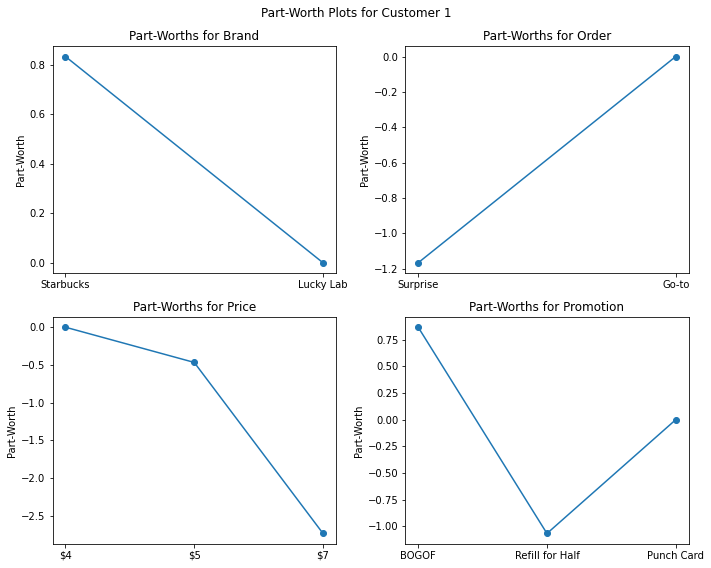

In [14]:
# Brand part-worth plot for Customer 1
brands = ['Starbucks', 'Lucky Lab']
starbucks_value = part_worths['Customer_1'].get("Starbucks")
lucky_lab_value = part_worths['Customer_1'].get("Lucky Lab")

# Order part-worth plot for Customer 1
orders = ['Surprise', 'Go-to']
surprise_value = part_worths['Customer_1'].get("Surprise")
go_to_value = part_worths['Customer_1'].get("Go-to")

# Price part-worth plot for Customer 1
prices = ['$4', '$5', '$7']
four_dollars = part_worths['Customer_1'].get("4 Dollars")
five_dollars = part_worths['Customer_1'].get("5 Dollars")
seven_dollars = part_worths['Customer_1'].get("7 Dollars")

# Promotion part-worth plot for Customer 1
promos = ['BOGOF', 'Refill for Half', 'Punch Card']
bogof_value = part_worths['Customer_1'].get("BOGOF")
refill_value = part_worths['Customer_1'].get("Refill for Half")
punch_card_value = part_worths['Customer_1'].get("Punch card")

# Updating totals for market level analysis
starbucks_total += starbucks_value
lucky_lab_total += lucky_lab_value
surprise_total += surprise_value
go_to_total += go_to_value
four_dollars_total += four_dollars
five_dollars_total += five_dollars
seven_dollars_total += seven_dollars
bogof_total += bogof_value
refill_total += refill_value
punch_card_total += punch_card_value

# Creating plots
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.plot(brands, [starbucks_value, lucky_lab_value], marker='o', linestyle='-')
plt.ylabel('Part-Worth')
plt.title('Part-Worths for Brand')
plt.subplot(2, 2, 2)
plt.plot(orders, [surprise_value, go_to_value], marker='o', linestyle='-')
plt.ylabel('Part-Worth')
plt.title('Part-Worths for Order')
plt.subplot(2, 2, 3)
plt.plot(prices, [four_dollars, five_dollars, seven_dollars], marker='o', linestyle='-')
plt.ylabel('Part-Worth')
plt.title('Part-Worths for Price')
plt.subplot(2, 2, 4)
plt.plot(promos, [bogof_value, refill_value, punch_card_value], marker='o', linestyle='-')
plt.ylabel('Part-Worth')
plt.title('Part-Worths for Promotion')
plt.suptitle('Part-Worth Plots for Customer 1')
plt.tight_layout()
plt.show()

In [15]:
# Print outputs for Customer 2
print_dict_in_table(part_worths['Customer_2'], "Part-Worths for Customer 2")
print_dict_in_table(attribute_ranges['Customer_2'], "Attribute Ranges for Customer 2")
print_dict_in_table(relative_importances['Customer_2'], "Relative Importances for Customer 2")

Part-Worths for Customer 2
--------------------------
Starbucks           : 3.5
Surprise            : 0.17
5 Dollars           : -0.4
7 Dollars           : -0.8
BOGOF               : 0.6
Refill for Half     : 0.2
Lucky Lab           : 0
Go-to               : 0
4 Dollars           : 0
Punch card          : 0

Attribute Ranges for Customer 2
-------------------------------
Brand               : 3.5
Order               : 0.17
Price               : 0.8
Promotion           : 0.6

Relative Importances for Customer 2
-----------------------------------
Brand               : 69.08
Order               : 3.29
Price               : 15.79
Promotion           : 11.84



In [16]:
# Average price per util for Customer 2

# $7 - $5 = 2
five_to_seven = 2/(part_worths['Customer_2'].get("7 Dollars") - part_worths['Customer_2'].get("5 Dollars"))
# $5 - $4 = 1
four_to_five = 1/(part_worths['Customer_2'].get("5 Dollars") - part_worths['Customer_2'].get("4 Dollars"))

price_per_util = (five_to_seven + four_to_five)/2
avg_price_per_util += round(price_per_util, 2)
print(round(price_per_util, 2))

-3.75


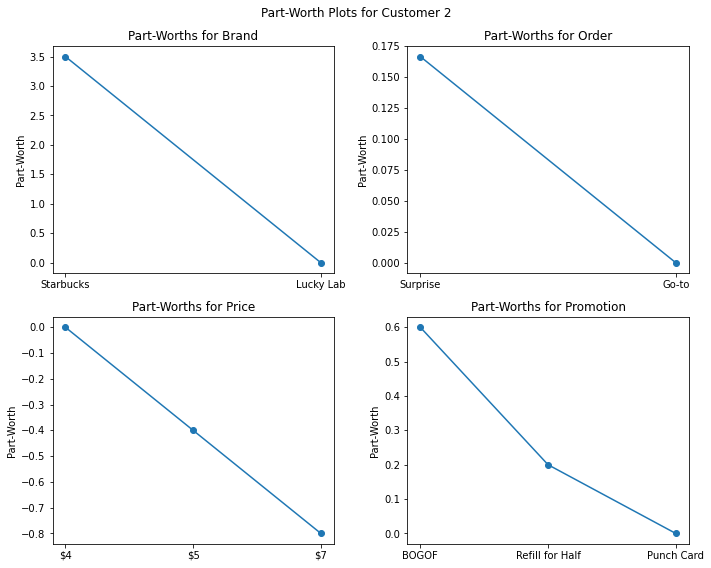

In [17]:
# Brand part-worth plot for Customer 2
brands = ['Starbucks', 'Lucky Lab']
starbucks_value = part_worths['Customer_2'].get("Starbucks")
lucky_lab_value = part_worths['Customer_2'].get("Lucky Lab")

# Order part-worth plot for Customer 2
orders = ['Surprise', 'Go-to']
surprise_value = part_worths['Customer_2'].get("Surprise")
go_to_value = part_worths['Customer_2'].get("Go-to")

# Price part-worth plot for Customer 2
prices = ['$4', '$5', '$7']
four_dollars = part_worths['Customer_2'].get("4 Dollars")
five_dollars = part_worths['Customer_2'].get("5 Dollars")
seven_dollars = part_worths['Customer_2'].get("7 Dollars")

# Promotion part-worth plot for Customer 2
promos = ['BOGOF', 'Refill for Half', 'Punch Card']
bogof_value = part_worths['Customer_2'].get("BOGOF")
refill_value = part_worths['Customer_2'].get("Refill for Half")
punch_card_value = part_worths['Customer_2'].get("Punch card")

# Updating totals for market level analysis
starbucks_total += starbucks_value
lucky_lab_total += lucky_lab_value
surprise_total += surprise_value
go_to_total += go_to_value
four_dollars_total += four_dollars
five_dollars_total += five_dollars
seven_dollars_total += seven_dollars
bogof_total += bogof_value
refill_total += refill_value
punch_card_total += punch_card_value

# Creating plots
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.plot(brands, [starbucks_value, lucky_lab_value], marker='o', linestyle='-')
plt.ylabel('Part-Worth')
plt.title('Part-Worths for Brand')
plt.subplot(2, 2, 2)
plt.plot(orders, [surprise_value, go_to_value], marker='o', linestyle='-')
plt.ylabel('Part-Worth')
plt.title('Part-Worths for Order')
plt.subplot(2, 2, 3)
plt.plot(prices, [four_dollars, five_dollars, seven_dollars], marker='o', linestyle='-')
plt.ylabel('Part-Worth')
plt.title('Part-Worths for Price')
plt.subplot(2, 2, 4)
plt.plot(promos, [bogof_value, refill_value, punch_card_value], marker='o', linestyle='-')
plt.ylabel('Part-Worth')
plt.title('Part-Worths for Promotion')
plt.suptitle('Part-Worth Plots for Customer 2')
plt.tight_layout()
plt.show()

In [18]:
# Print outputs for Customer 3
print_dict_in_table(part_worths['Customer_3'], "Part-Worths for Customer 3")
print_dict_in_table(attribute_ranges['Customer_3'], "Attribute Ranges for Customer 3")
print_dict_in_table(relative_importances['Customer_3'], "Relative Importances for Customer 3")

Part-Worths for Customer 3
--------------------------
Starbucks           : 0.67
Surprise            : 0.33
5 Dollars           : -1.27
7 Dollars           : -4.93
BOGOF               : 0.07
Refill for Half     : -0.27
Lucky Lab           : 0
Go-to               : 0
4 Dollars           : 0
Punch card          : 0

Attribute Ranges for Customer 3
-------------------------------
Brand               : 0.67
Order               : 0.33
Price               : 4.93
Promotion           : 0.33

Relative Importances for Customer 3
-----------------------------------
Brand               : 10.64
Order               : 5.32
Price               : 78.72
Promotion           : 5.32



In [19]:
# Average price per util for Customer 3

# $7 - $5 = 2
five_to_seven = 2/(part_worths['Customer_3'].get("7 Dollars") - part_worths['Customer_3'].get("5 Dollars"))
# $5 - $4 = 1
four_to_five = 1/(part_worths['Customer_3'].get("5 Dollars") - part_worths['Customer_3'].get("4 Dollars"))

price_per_util = (five_to_seven + four_to_five)/2
avg_price_per_util += round(price_per_util, 2)
print(round(price_per_util, 2))

-0.67


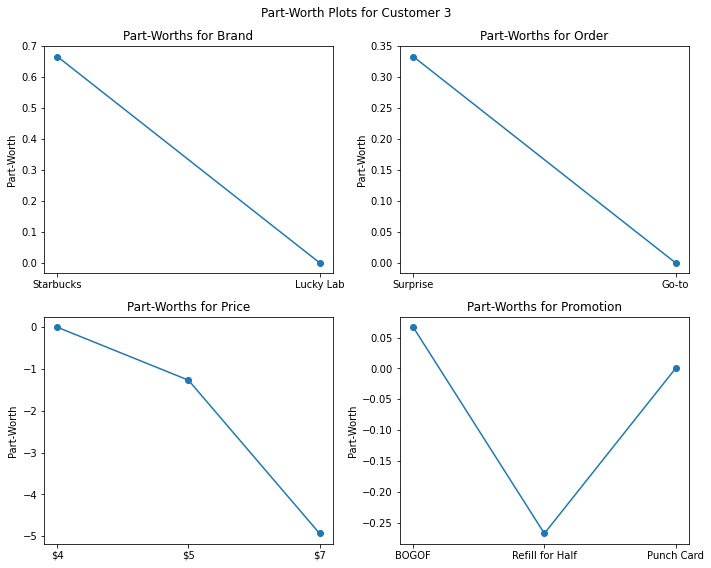

In [20]:
# Brand part-worth plot for Customer 3
brands = ['Starbucks', 'Lucky Lab']
starbucks_value = part_worths['Customer_3'].get("Starbucks")
lucky_lab_value = part_worths['Customer_3'].get("Lucky Lab")

# Order part-worth plot for Customer 3
orders = ['Surprise', 'Go-to']
surprise_value = part_worths['Customer_3'].get("Surprise")
go_to_value = part_worths['Customer_3'].get("Go-to")

# Price part-worth plot for Customer 3
prices = ['$4', '$5', '$7']
four_dollars = part_worths['Customer_3'].get("4 Dollars")
five_dollars = part_worths['Customer_3'].get("5 Dollars")
seven_dollars = part_worths['Customer_3'].get("7 Dollars")

# Promotion part-worth plot for Customer 3
promos = ['BOGOF', 'Refill for Half', 'Punch Card']
bogof_value = part_worths['Customer_3'].get("BOGOF")
refill_value = part_worths['Customer_3'].get("Refill for Half")
punch_card_value = part_worths['Customer_3'].get("Punch card")

# Updating totals for market level analysis
starbucks_total += starbucks_value
lucky_lab_total += lucky_lab_value
surprise_total += surprise_value
go_to_total += go_to_value
four_dollars_total += four_dollars
five_dollars_total += five_dollars
seven_dollars_total += seven_dollars
bogof_total += bogof_value
refill_total += refill_value
punch_card_total += punch_card_value

# Creating plots
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.plot(brands, [starbucks_value, lucky_lab_value], marker='o', linestyle='-')
plt.ylabel('Part-Worth')
plt.title('Part-Worths for Brand')
plt.subplot(2, 2, 2)
plt.plot(orders, [surprise_value, go_to_value], marker='o', linestyle='-')
plt.ylabel('Part-Worth')
plt.title('Part-Worths for Order')
plt.subplot(2, 2, 3)
plt.plot(prices, [four_dollars, five_dollars, seven_dollars], marker='o', linestyle='-')
plt.ylabel('Part-Worth')
plt.title('Part-Worths for Price')
plt.subplot(2, 2, 4)
plt.plot(promos, [bogof_value, refill_value, punch_card_value], marker='o', linestyle='-')
plt.ylabel('Part-Worth')
plt.title('Part-Worths for Promotion')
plt.suptitle('Part-Worth Plots for Customer 3')
plt.tight_layout()
plt.show()

In [21]:
# Print outputs for Customer 4
print_dict_in_table(part_worths['Customer_4'], "Part-Worths for Customer 4")
print_dict_in_table(attribute_ranges['Customer_4'], "Attribute Ranges for Customer 4")
print_dict_in_table(relative_importances['Customer_4'], "Relative Importances for Customer 4")

Part-Worths for Customer 4
--------------------------
Starbucks           : 1.5
Surprise            : -1.17
5 Dollars           : -1.67
7 Dollars           : -0.53
BOGOF               : 3.67
Refill for Half     : 0.13
Lucky Lab           : 0
Go-to               : 0
4 Dollars           : 0
Punch card          : 0

Attribute Ranges for Customer 4
-------------------------------
Brand               : 1.5
Order               : 1.17
Price               : 1.67
Promotion           : 3.67

Relative Importances for Customer 4
-----------------------------------
Brand               : 18.75
Order               : 14.58
Price               : 20.83
Promotion           : 45.83



In [22]:
# Average price per util for Customer 4

# $7 - $5 = 2
five_to_seven = 2/(part_worths['Customer_4'].get("7 Dollars") - part_worths['Customer_4'].get("5 Dollars"))
# $5 - $4 = 1
four_to_five = 1/(part_worths['Customer_4'].get("5 Dollars") - part_worths['Customer_4'].get("4 Dollars"))

price_per_util = (five_to_seven + four_to_five)/2
avg_price_per_util += round(price_per_util, 2)
print(round(price_per_util, 2))

0.58


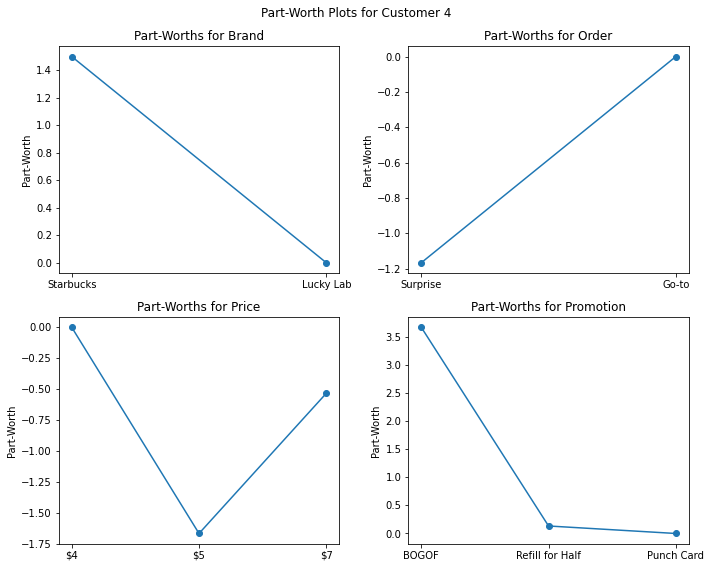

In [23]:
# Brand part-worth plot for Customer 4
brands = ['Starbucks', 'Lucky Lab']
starbucks_value = part_worths['Customer_4'].get("Starbucks")
lucky_lab_value = part_worths['Customer_4'].get("Lucky Lab")

# Order part-worth plot for Customer 4
orders = ['Surprise', 'Go-to']
surprise_value = part_worths['Customer_4'].get("Surprise")
go_to_value = part_worths['Customer_4'].get("Go-to")

# Price part-worth plot for Customer 4
prices = ['$4', '$5', '$7']
four_dollars = part_worths['Customer_4'].get("4 Dollars")
five_dollars = part_worths['Customer_4'].get("5 Dollars")
seven_dollars = part_worths['Customer_4'].get("7 Dollars")

# Promotion part-worth plot for Customer 4
promos = ['BOGOF', 'Refill for Half', 'Punch Card']
bogof_value = part_worths['Customer_4'].get("BOGOF")
refill_value = part_worths['Customer_4'].get("Refill for Half")
punch_card_value = part_worths['Customer_4'].get("Punch card")

# Updating totals for market level analysis
starbucks_total += starbucks_value
lucky_lab_total += lucky_lab_value
surprise_total += surprise_value
go_to_total += go_to_value
four_dollars_total += four_dollars
five_dollars_total += five_dollars
seven_dollars_total += seven_dollars
bogof_total += bogof_value
refill_total += refill_value
punch_card_total += punch_card_value

# Creating plots
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.plot(brands, [starbucks_value, lucky_lab_value], marker='o', linestyle='-')
plt.ylabel('Part-Worth')
plt.title('Part-Worths for Brand')
plt.subplot(2, 2, 2)
plt.plot(orders, [surprise_value, go_to_value], marker='o', linestyle='-')
plt.ylabel('Part-Worth')
plt.title('Part-Worths for Order')
plt.subplot(2, 2, 3)
plt.plot(prices, [four_dollars, five_dollars, seven_dollars], marker='o', linestyle='-')
plt.ylabel('Part-Worth')
plt.title('Part-Worths for Price')
plt.subplot(2, 2, 4)
plt.plot(promos, [bogof_value, refill_value, punch_card_value], marker='o', linestyle='-')
plt.ylabel('Part-Worth')
plt.title('Part-Worths for Promotion')
plt.suptitle('Part-Worth Plots for Customer 4')
plt.tight_layout()
plt.show()

In [24]:
# Print outputs for Customer 5
print_dict_in_table(part_worths['Customer_5'], "Part-Worths for Customer 5")
print_dict_in_table(attribute_ranges['Customer_5'], "Attribute Ranges for Customer 5")
print_dict_in_table(relative_importances['Customer_5'], "Relative Importances for Customer 5")

Part-Worths for Customer 5
--------------------------
Starbucks           : -0.67
Surprise            : 0.67
5 Dollars           : -2.73
7 Dollars           : 0.93
BOGOF               : 0.93
Refill for Half     : -2.73
Lucky Lab           : 0
Go-to               : 0
4 Dollars           : 0
Punch card          : 0

Attribute Ranges for Customer 5
-------------------------------
Brand               : 0.67
Order               : 0.67
Price               : 3.67
Promotion           : 3.67

Relative Importances for Customer 5
-----------------------------------
Brand               : 7.69
Order               : 7.69
Price               : 42.31
Promotion           : 42.31



In [25]:
# Average price per util for Customer 5

# $7 - $5 = 2
five_to_seven = 2/(part_worths['Customer_5'].get("7 Dollars") - part_worths['Customer_5'].get("5 Dollars"))
# $5 - $4 = 1
four_to_five = 1/(part_worths['Customer_5'].get("5 Dollars") - part_worths['Customer_5'].get("4 Dollars"))

price_per_util = (five_to_seven + four_to_five)/2
avg_price_per_util += round(price_per_util, 2)
print(round(price_per_util, 2))

0.09


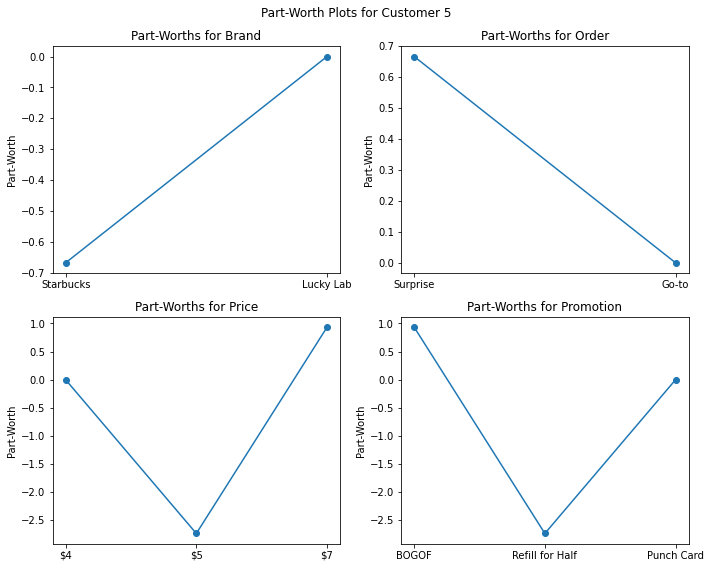

In [26]:
# Brand part-worth plot for Customer 5
brands = ['Starbucks', 'Lucky Lab']
starbucks_value = part_worths['Customer_5'].get("Starbucks")
lucky_lab_value = part_worths['Customer_5'].get("Lucky Lab")

# Order part-worth plot for Customer 5
orders = ['Surprise', 'Go-to']
surprise_value = part_worths['Customer_5'].get("Surprise")
go_to_value = part_worths['Customer_5'].get("Go-to")

# Price part-worth plot for Customer 5
prices = ['$4', '$5', '$7']
four_dollars = part_worths['Customer_5'].get("4 Dollars")
five_dollars = part_worths['Customer_5'].get("5 Dollars")
seven_dollars = part_worths['Customer_5'].get("7 Dollars")

# Promotion part-worth plot for Customer 5
promos = ['BOGOF', 'Refill for Half', 'Punch Card']
bogof_value = part_worths['Customer_5'].get("BOGOF")
refill_value = part_worths['Customer_5'].get("Refill for Half")
punch_card_value = part_worths['Customer_5'].get("Punch card")

# Updating totals for market level analysis
starbucks_total += starbucks_value
lucky_lab_total += lucky_lab_value
surprise_total += surprise_value
go_to_total += go_to_value
four_dollars_total += four_dollars
five_dollars_total += five_dollars
seven_dollars_total += seven_dollars
bogof_total += bogof_value
refill_total += refill_value
punch_card_total += punch_card_value

# Creating plots
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.plot(brands, [starbucks_value, lucky_lab_value], marker='o', linestyle='-')
plt.ylabel('Part-Worth')
plt.title('Part-Worths for Brand')
plt.subplot(2, 2, 2)
plt.plot(orders, [surprise_value, go_to_value], marker='o', linestyle='-')
plt.ylabel('Part-Worth')
plt.title('Part-Worths for Order')
plt.subplot(2, 2, 3)
plt.plot(prices, [four_dollars, five_dollars, seven_dollars], marker='o', linestyle='-')
plt.ylabel('Part-Worth')
plt.title('Part-Worths for Price')
plt.subplot(2, 2, 4)
plt.plot(promos, [bogof_value, refill_value, punch_card_value], marker='o', linestyle='-')
plt.ylabel('Part-Worth')
plt.title('Part-Worths for Promotion')
plt.suptitle('Part-Worth Plots for Customer 5')
plt.tight_layout()
plt.show()

In [27]:
# Print outputs for Customer 6
print_dict_in_table(part_worths['Customer_6'], "Part-Worths for Customer 6")
print_dict_in_table(attribute_ranges['Customer_6'], "Attribute Ranges for Customer 6")
print_dict_in_table(relative_importances['Customer_6'], "Relative Importances for Customer 6")

Part-Worths for Customer 6
--------------------------
Starbucks           : 0.67
Surprise            : 0.33
5 Dollars           : -0.87
7 Dollars           : -3.73
BOGOF               : 2.47
Refill for Half     : 1.93
Lucky Lab           : 0
Go-to               : 0
4 Dollars           : 0
Punch card          : 0

Attribute Ranges for Customer 6
-------------------------------
Brand               : 0.67
Order               : 0.33
Price               : 3.73
Promotion           : 2.47

Relative Importances for Customer 6
-----------------------------------
Brand               : 9.26
Order               : 4.63
Price               : 51.85
Promotion           : 34.26



In [28]:
# Average price per util for Customer 6

# $7 - $5 = 2
five_to_seven = 2/(part_worths['Customer_6'].get("7 Dollars") - part_worths['Customer_6'].get("5 Dollars"))
# $5 - $4 = 1
four_to_five = 1/(part_worths['Customer_6'].get("5 Dollars") - part_worths['Customer_6'].get("4 Dollars"))

price_per_util = (five_to_seven + four_to_five)/2
avg_price_per_util += round(price_per_util, 2)
print(round(price_per_util, 2))

-0.93


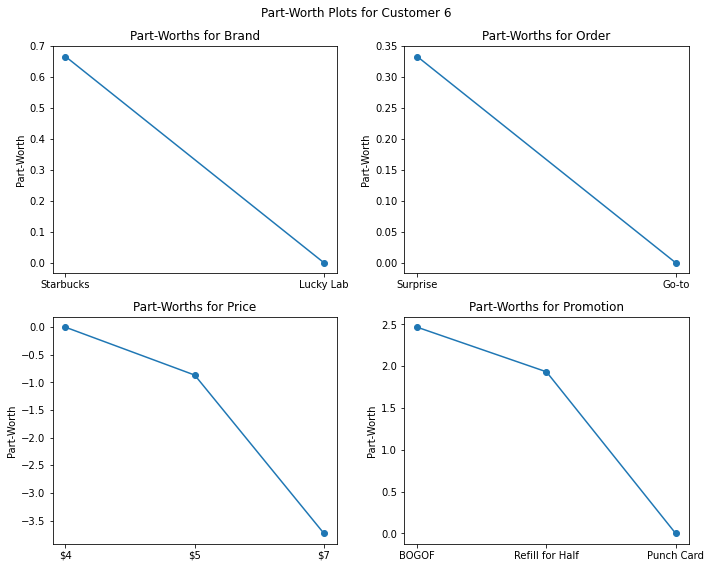

In [29]:
# Brand part-worth plot for Customer 6
brands = ['Starbucks', 'Lucky Lab']
starbucks_value = part_worths['Customer_6'].get("Starbucks")
lucky_lab_value = part_worths['Customer_6'].get("Lucky Lab")

# Order part-worth plot for Customer 6
orders = ['Surprise', 'Go-to']
surprise_value = part_worths['Customer_6'].get("Surprise")
go_to_value = part_worths['Customer_6'].get("Go-to")

# Price part-worth plot for Customer 6
prices = ['$4', '$5', '$7']
four_dollars = part_worths['Customer_6'].get("4 Dollars")
five_dollars = part_worths['Customer_6'].get("5 Dollars")
seven_dollars = part_worths['Customer_6'].get("7 Dollars")

# Promotion part-worth plot for Customer 6
promos = ['BOGOF', 'Refill for Half', 'Punch Card']
bogof_value = part_worths['Customer_6'].get("BOGOF")
refill_value = part_worths['Customer_6'].get("Refill for Half")
punch_card_value = part_worths['Customer_6'].get("Punch card")

# Updating totals for market level analysis
starbucks_total += starbucks_value
lucky_lab_total += lucky_lab_value
surprise_total += surprise_value
go_to_total += go_to_value
four_dollars_total += four_dollars
five_dollars_total += five_dollars
seven_dollars_total += seven_dollars
bogof_total += bogof_value
refill_total += refill_value
punch_card_total += punch_card_value

# Creating plots
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.plot(brands, [starbucks_value, lucky_lab_value], marker='o', linestyle='-')
plt.ylabel('Part-Worth')
plt.title('Part-Worths for Brand')
plt.subplot(2, 2, 2)
plt.plot(orders, [surprise_value, go_to_value], marker='o', linestyle='-')
plt.ylabel('Part-Worth')
plt.title('Part-Worths for Order')
plt.subplot(2, 2, 3)
plt.plot(prices, [four_dollars, five_dollars, seven_dollars], marker='o', linestyle='-')
plt.ylabel('Part-Worth')
plt.title('Part-Worths for Price')
plt.subplot(2, 2, 4)
plt.plot(promos, [bogof_value, refill_value, punch_card_value], marker='o', linestyle='-')
plt.ylabel('Part-Worth')
plt.title('Part-Worths for Promotion')
plt.suptitle('Part-Worth Plots for Customer 6')
plt.tight_layout()
plt.show()

In [30]:
# Print outputs for Customer 7
print_dict_in_table(part_worths['Customer_7'], "Part-Worths for Customer 7")
print_dict_in_table(attribute_ranges['Customer_7'], "Attribute Ranges for Customer 7")
print_dict_in_table(relative_importances['Customer_7'], "Relative Importances for Customer 7")

Part-Worths for Customer 7
--------------------------
Starbucks           : 0.17
Surprise            : -1.83
5 Dollars           : 0.4
7 Dollars           : -1.2
BOGOF               : 0.4
Refill for Half     : -1.2
Lucky Lab           : 0
Go-to               : 0
4 Dollars           : 0
Punch card          : 0

Attribute Ranges for Customer 7
-------------------------------
Brand               : 0.17
Order               : 1.83
Price               : 1.6
Promotion           : 1.6

Relative Importances for Customer 7
-----------------------------------
Brand               : 3.21
Order               : 35.26
Price               : 30.77
Promotion           : 30.77



In [31]:
# Average price per util for Customer 7

# $7 - $5 = 2
five_to_seven = 2/(part_worths['Customer_7'].get("7 Dollars") - part_worths['Customer_7'].get("5 Dollars"))
# $5 - $4 = 1
four_to_five = 1/(part_worths['Customer_7'].get("5 Dollars") - part_worths['Customer_7'].get("4 Dollars"))

price_per_util = (five_to_seven + four_to_five)/2
avg_price_per_util += round(price_per_util, 2)
print(round(price_per_util, 2))

0.62


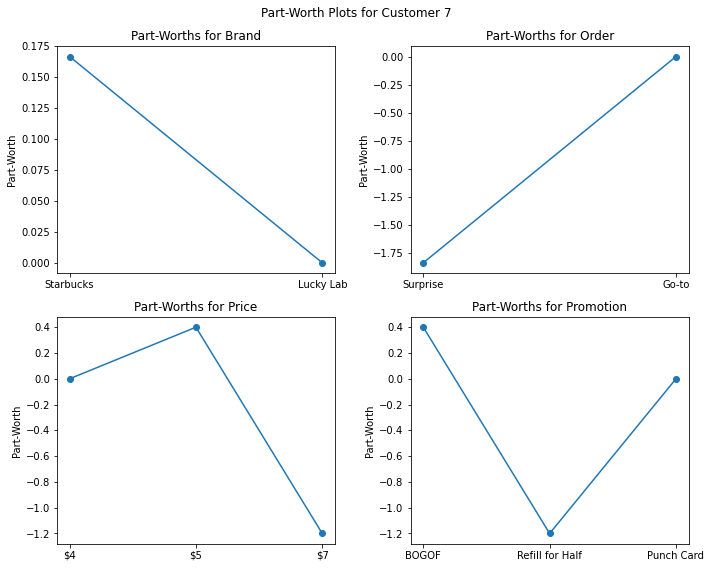

In [32]:
# Brand part-worth plot for Customer 7
brands = ['Starbucks', 'Lucky Lab']
starbucks_value = part_worths['Customer_7'].get("Starbucks")
lucky_lab_value = part_worths['Customer_7'].get("Lucky Lab")

# Order part-worth plot for Customer 7
orders = ['Surprise', 'Go-to']
surprise_value = part_worths['Customer_7'].get("Surprise")
go_to_value = part_worths['Customer_7'].get("Go-to")

# Price part-worth plot for Customer 7
prices = ['$4', '$5', '$7']
four_dollars = part_worths['Customer_7'].get("4 Dollars")
five_dollars = part_worths['Customer_7'].get("5 Dollars")
seven_dollars = part_worths['Customer_7'].get("7 Dollars")

# Promotion part-worth plot for Customer 7
promos = ['BOGOF', 'Refill for Half', 'Punch Card']
bogof_value = part_worths['Customer_7'].get("BOGOF")
refill_value = part_worths['Customer_7'].get("Refill for Half")
punch_card_value = part_worths['Customer_7'].get("Punch card")

# Updating totals for market level analysis
starbucks_total += starbucks_value
lucky_lab_total += lucky_lab_value
surprise_total += surprise_value
go_to_total += go_to_value
four_dollars_total += four_dollars
five_dollars_total += five_dollars
seven_dollars_total += seven_dollars
bogof_total += bogof_value
refill_total += refill_value
punch_card_total += punch_card_value

# Creating plots
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.plot(brands, [starbucks_value, lucky_lab_value], marker='o', linestyle='-')
plt.ylabel('Part-Worth')
plt.title('Part-Worths for Brand')
plt.subplot(2, 2, 2)
plt.plot(orders, [surprise_value, go_to_value], marker='o', linestyle='-')
plt.ylabel('Part-Worth')
plt.title('Part-Worths for Order')
plt.subplot(2, 2, 3)
plt.plot(prices, [four_dollars, five_dollars, seven_dollars], marker='o', linestyle='-')
plt.ylabel('Part-Worth')
plt.title('Part-Worths for Price')
plt.subplot(2, 2, 4)
plt.plot(promos, [bogof_value, refill_value, punch_card_value], marker='o', linestyle='-')
plt.ylabel('Part-Worth')
plt.title('Part-Worths for Promotion')
plt.suptitle('Part-Worth Plots for Customer 7')
plt.tight_layout()
plt.show()

In [33]:
# Print outputs for Customer 8
print_dict_in_table(part_worths['Customer_8'], "Part-Worths for Customer 8")
print_dict_in_table(attribute_ranges['Customer_8'], "Attribute Ranges for Customer 8")
print_dict_in_table(relative_importances['Customer_8'], "Relative Importances for Customer 8")

Part-Worths for Customer 8
--------------------------
Starbucks           : -0.33
Surprise            : -0.0
5 Dollars           : 0.13
7 Dollars           : -4.53
BOGOF               : 1.47
Refill for Half     : 0.13
Lucky Lab           : 0
Go-to               : 0
4 Dollars           : 0
Punch card          : 0

Attribute Ranges for Customer 8
-------------------------------
Brand               : 0.33
Order               : 0.0
Price               : 4.67
Promotion           : 1.47

Relative Importances for Customer 8
-----------------------------------
Brand               : 5.15
Order               : 0.0
Price               : 72.16
Promotion           : 22.68



In [34]:
# Average price per util for Customer 8

# $7 - $5 = 2
five_to_seven = 2/(part_worths['Customer_8'].get("7 Dollars") - part_worths['Customer_8'].get("5 Dollars"))
# -0.42918454935
# $5 - $4 = 1
four_to_five = 1/(part_worths['Customer_8'].get("5 Dollars") - part_worths['Customer_8'].get("4 Dollars"))
# 7.69230769231

price_per_util = (five_to_seven + four_to_five)/2
avg_price_per_util += round(price_per_util, 2)
print(round(price_per_util, 2))

3.54


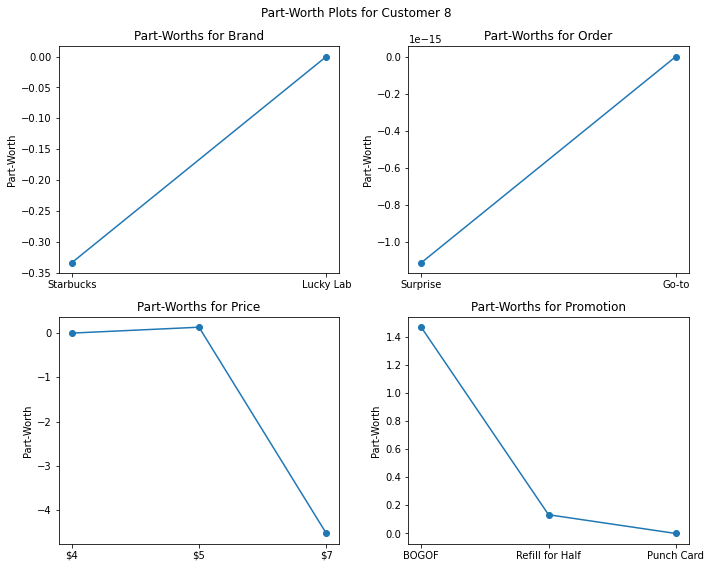

In [36]:
# Brand part-worth plot for Customer 8
brands = ['Starbucks', 'Lucky Lab']
starbucks_value = part_worths['Customer_8'].get("Starbucks")
lucky_lab_value = part_worths['Customer_8'].get("Lucky Lab")

# Order part-worth plot for Customer 8
orders = ['Surprise', 'Go-to']
surprise_value = part_worths['Customer_8'].get("Surprise")
go_to_value = part_worths['Customer_8'].get("Go-to")

# Price part-worth plot for Customer 8
prices = ['$4', '$5', '$7']
four_dollars = part_worths['Customer_8'].get("4 Dollars")
five_dollars = part_worths['Customer_8'].get("5 Dollars")
seven_dollars = part_worths['Customer_8'].get("7 Dollars")

# Promotion part-worth plot for Customer 8
promos = ['BOGOF', 'Refill for Half', 'Punch Card']
bogof_value = part_worths['Customer_8'].get("BOGOF")
refill_value = part_worths['Customer_8'].get("Refill for Half")
punch_card_value = part_worths['Customer_8'].get("Punch card")

# Updating totals for market level analysis
starbucks_total += starbucks_value
lucky_lab_total += lucky_lab_value
surprise_total += surprise_value
go_to_total += go_to_value
four_dollars_total += four_dollars
five_dollars_total += five_dollars
seven_dollars_total += seven_dollars
bogof_total += bogof_value
refill_total += refill_value
punch_card_total += punch_card_value

# Creating plots
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.plot(brands, [starbucks_value, lucky_lab_value], marker='o', linestyle='-')
plt.ylabel('Part-Worth')
plt.title('Part-Worths for Brand')
plt.subplot(2, 2, 2)
plt.plot(orders, [surprise_value, go_to_value], marker='o', linestyle='-')
plt.ylabel('Part-Worth')
plt.title('Part-Worths for Order')
plt.subplot(2, 2, 3)
plt.plot(prices, [four_dollars, five_dollars, seven_dollars], marker='o', linestyle='-')
plt.ylabel('Part-Worth')
plt.title('Part-Worths for Price')
plt.subplot(2, 2, 4)
plt.plot(promos, [bogof_value, refill_value, punch_card_value], marker='o', linestyle='-')
plt.ylabel('Part-Worth')
plt.title('Part-Worths for Promotion')
plt.suptitle('Part-Worth Plots for Customer 8')
plt.tight_layout()
plt.show()

## Market Level Attribute Importance

   Attribute  Percentage (Relative Importance)
0      Brand                             17.03
1      Order                             11.03
2      Price                             44.18
3  Promotion                             27.75

Average Part-Worths:

Starbucks: 0.7916666666666633
Lucky Lab: 0.0
Surprise: -0.33333333333333415
Go-to: 0.0
4 Dollars: 0.0
5 Dollars: -0.8583333333333336
7 Dollars: -2.1916666666666664
BOGOF: 1.308333333333334
Refill for Half: -0.35833333333333256
Punch card:0.0

Average Price per Util: -0.2537499999999999



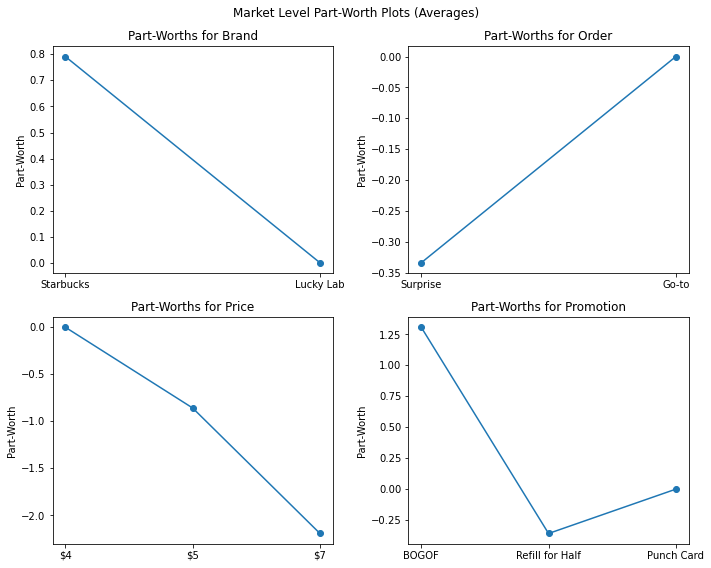

In [37]:
# Initialize a dictionary to sum relative importances for each attribute
sum_relative_importances = {attribute: 0 for attribute in attribute_mapping}

# Count the number of customers
num_customers = len(relative_importances)

# Sum the relative importances for each attribute across all customers
for customer in relative_importances:
    for attribute, importance in relative_importances[customer].items():
        sum_relative_importances[attribute] += importance

# Calculate the average relative importance for each attribute
avg_relative_importances = {attribute: round(sum_importance / num_customers, 2)
                            for attribute, sum_importance in sum_relative_importances.items()}

# Create a DataFrame from the average relative importances
avg_rel_importance_df = pd.DataFrame(list(avg_relative_importances.items()),
                                     columns=['Attribute', 'Percentage (Relative Importance)'])

# Print the DataFrame
print(avg_rel_importance_df)
print()

# Print market level average part-worths
print("Average Part-Worths:")
print()
print("Starbucks: " + str(starbucks_total/8))
print("Lucky Lab: " + str(lucky_lab_total/8))
print("Surprise: " + str(surprise_total/8))
print("Go-to: " + str(go_to_total/8))
print("4 Dollars: " + str(four_dollars_total/8))
print("5 Dollars: " + str(five_dollars_total/8))
print("7 Dollars: " + str(seven_dollars_total/8))
print("BOGOF: " + str(bogof_total/8))
print("Refill for Half: " + str(refill_total/8))
print("Punch card:" + str(punch_card_total/8))
print()

# Average price per util
avg_price_per_util = avg_price_per_util/8
print("Average Price per Util: " + str(avg_price_per_util))
print()

plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.plot(brands, [starbucks_total/8, lucky_lab_total/8], marker='o', linestyle='-')
plt.ylabel('Part-Worth')
plt.title('Part-Worths for Brand')
plt.subplot(2, 2, 2)
plt.plot(orders, [surprise_total/8, go_to_total/8], marker='o', linestyle='-')
plt.ylabel('Part-Worth')
plt.title('Part-Worths for Order')
plt.subplot(2, 2, 3)
plt.plot(prices, [four_dollars_total/8, five_dollars_total/8, seven_dollars_total/8], marker='o', linestyle='-')
plt.ylabel('Part-Worth')
plt.title('Part-Worths for Price')
plt.subplot(2, 2, 4)
plt.plot(promos, [bogof_total/8, refill_total/8, punch_card_total/8], marker='o', linestyle='-')
plt.ylabel('Part-Worth')
plt.title('Part-Worths for Promotion')
plt.suptitle('Market Level Part-Worth Plots (Averages)')
plt.tight_layout()
plt.show()